In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support,
    fbeta_score
)
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load the Preprocessed OPP-115 Data

In [2]:
# Load the preprocessed datasets
train_df = pd.read_csv('Input/opp115_train.csv')
test_df = pd.read_csv('Input/opp115_test.csv')

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nClass labels: {train_df['target'].unique()}")

Training set: 14336 samples
Test set: 2480 samples

Columns: ['ID', 'Sentence', 'target', 'label', 'dataset_type', 'policy_name']

Class labels: ['Other' 'ThirdPartySharing' 'DataCollection' 'DataSecurity' 'UserRights'
 'PolicyChange' 'DataRetention' 'SpecialAudiences' 'DoNotTrack']


In [3]:
# Display sample data
train_df.head(10)

,ID,Sentence,target,label,dataset_type,policy_name
0,0,Web Privacy Statement,Other,8,train,austincc.edu
1,1,Austin Community College (ACC) is committed to...,Other,8,train,austincc.edu
2,2,personal information,ThirdPartySharing,1,train,austincc.edu
3,3,Open Records law to release information,ThirdPartySharing,1,train,austincc.edu
4,4,Open Records law to release information,ThirdPartySharing,1,train,austincc.edu
5,5,Open Records law to release information,ThirdPartySharing,1,train,austincc.edu
6,6,gathered from our Web servers.,DataCollection,0,train,austincc.edu
7,7,"some information collected from the ACC web site,",DataCollection,0,train,austincc.edu
8,8,committed to ensuring the privacy of personal ...,DataSecurity,4,train,austincc.edu
9,9,from the ACC web site,DataCollection,0,train,austincc.edu


## 2. Explore Class Distribution

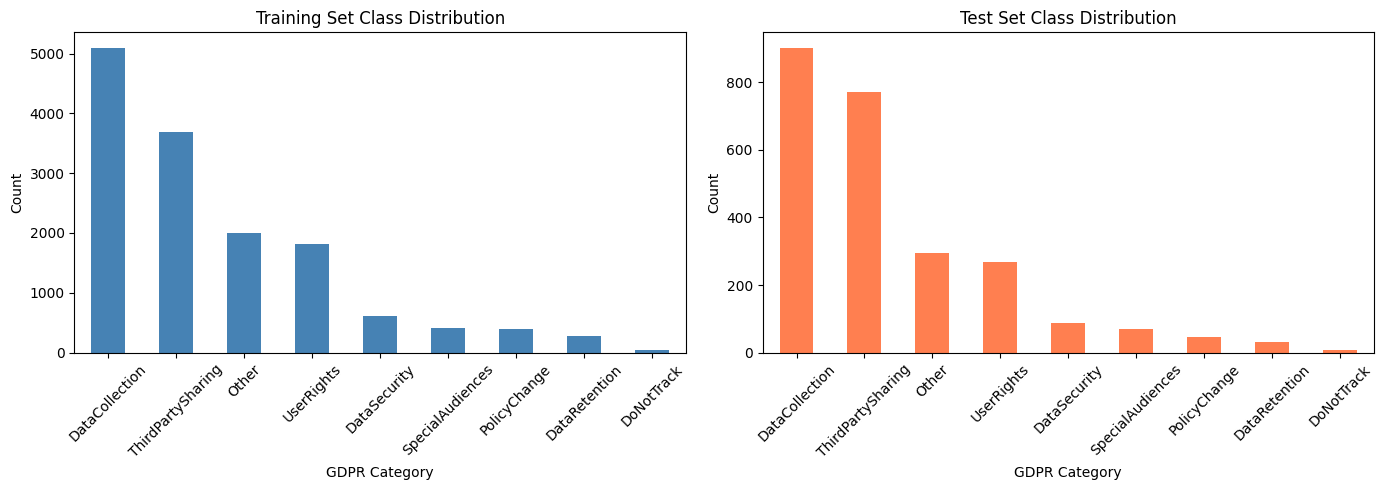


Training set class distribution:
target
DataCollection       5100
ThirdPartySharing    3687
Other                1997
UserRights           1812
DataSecurity          604
SpecialAudiences      416
PolicyChange          396
DataRetention         280
DoNotTrack             44
Name: count, dtype: int64


In [4]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
train_counts = train_df['target'].value_counts()
ax1 = axes[0]
train_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('GDPR Category')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Test set distribution
test_counts = test_df['target'].value_counts()
ax2 = axes[1]
test_counts.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Test Set Class Distribution')
ax2.set_xlabel('GDPR Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nTraining set class distribution:")
print(train_counts)

In [ ]:
# Sample texts per category
print("Sample texts per GDPR category:\n" + "="*60)
for category in train_df['target'].unique():
    samples = train_df[train_df['target'] == category]['Sentence'].sample(min(3, len(train_df[train_df['target'] == category])))
    print(f"\n{category}:")
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text[:100]}..." if len(text) > 100 else f"  {i}. {text}")

## 3. Prepare Data for Classification

In [5]:
# Split training data into train and validation based on dataset_type column
X_train_full = train_df['Sentence'].fillna('')
y_train_full = train_df['target']

X_test = test_df['Sentence'].fillna('')
y_test = test_df['target']

print(f"Training samples: {len(X_train_full)}")
print(f"Test samples: {len(X_test)}")

Training samples: 14336
Test samples: 2480


In [6]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train_full)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")

TF-IDF feature shape: (14336, 10000)


## 4. Train and Evaluate Lightweight Models

In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train model and evaluate on test set with all metrics."""
    import time
    
    # Training
    start_train = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_train
    
    # Inference
    start_inference = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_inference
    
    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    
    results = {
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,
        'train_time_sec': train_time,
        'inference_time_sec': inference_time,
        'inference_per_sample_ms': (inference_time / len(y_test)) * 1000
    }
    
    return results, y_pred

# Store results
all_results = []

In [8]:
# Model 1: Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_results, lr_pred = evaluate_model(lr_model, X_train_tfidf, y_train_full, X_test_tfidf, y_test, 'Logistic Regression')
all_results.append(lr_results)

print(f"\nLogistic Regression Results:")
print(f"  Precision: {lr_results['precision']:.4f}")
print(f"  Recall: {lr_results['recall']:.4f}")
print(f"  F1-Score: {lr_results['f1_score']:.4f}")
print(f"  F2-Score: {lr_results['f2_score']:.4f}")
print(f"  Training Time: {lr_results['train_time_sec']:.2f}s")
print(f"  Inference Time: {lr_results['inference_time_sec']:.4f}s ({lr_results['inference_per_sample_ms']:.4f}ms/sample)")

Training Logistic Regression...

Logistic Regression Results:
  Precision: 0.8139
  Recall: 0.7609
  F1-Score: 0.7801
  F2-Score: 0.7661
  Training Time: 31.90s
  Inference Time: 0.0017s (0.0007ms/sample)


In [9]:
# Model 2: Linear SVM
print("Training Linear SVM...")
svm_model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
svm_results, svm_pred = evaluate_model(svm_model, X_train_tfidf, y_train_full, X_test_tfidf, y_test, 'Linear SVM')
all_results.append(svm_results)

print(f"\nLinear SVM Results:")
print(f"  Precision: {svm_results['precision']:.4f}")
print(f"  Recall: {svm_results['recall']:.4f}")
print(f"  F1-Score: {svm_results['f1_score']:.4f}")
print(f"  F2-Score: {svm_results['f2_score']:.4f}")
print(f"  Training Time: {svm_results['train_time_sec']:.2f}s")
print(f"  Inference Time: {svm_results['inference_time_sec']:.4f}s ({svm_results['inference_per_sample_ms']:.4f}ms/sample)")

Training Linear SVM...

Linear SVM Results:
  Precision: 0.8147
  Recall: 0.7810
  F1-Score: 0.7942
  F2-Score: 0.7851
  Training Time: 11.18s
  Inference Time: 0.0014s (0.0006ms/sample)


## 5. Detailed Classification Report

In [10]:
# Classification report for best model (based on F1)
best_model_name = max(all_results, key=lambda x: x['f1_score'])['model']
best_pred = lr_pred if best_model_name == 'Logistic Regression' else svm_pred

print(f"\n{best_model_name} - Detailed Classification Report:")
print("="*70)
print(classification_report(y_test, best_pred))


Linear SVM - Detailed Classification Report:
                   precision    recall  f1-score   support

   DataCollection       0.87      0.77      0.82       903
    DataRetention       0.10      0.34      0.15        32
     DataSecurity       0.70      0.87      0.78        87
       DoNotTrack       1.00      0.67      0.80         9
            Other       0.59      0.73      0.65       294
     PolicyChange       0.79      0.89      0.84        47
 SpecialAudiences       0.78      0.68      0.73        69
ThirdPartySharing       0.92      0.86      0.89       771
       UserRights       0.71      0.69      0.70       268

         accuracy                           0.78      2480
        macro avg       0.72      0.72      0.71      2480
     weighted avg       0.81      0.78      0.79      2480



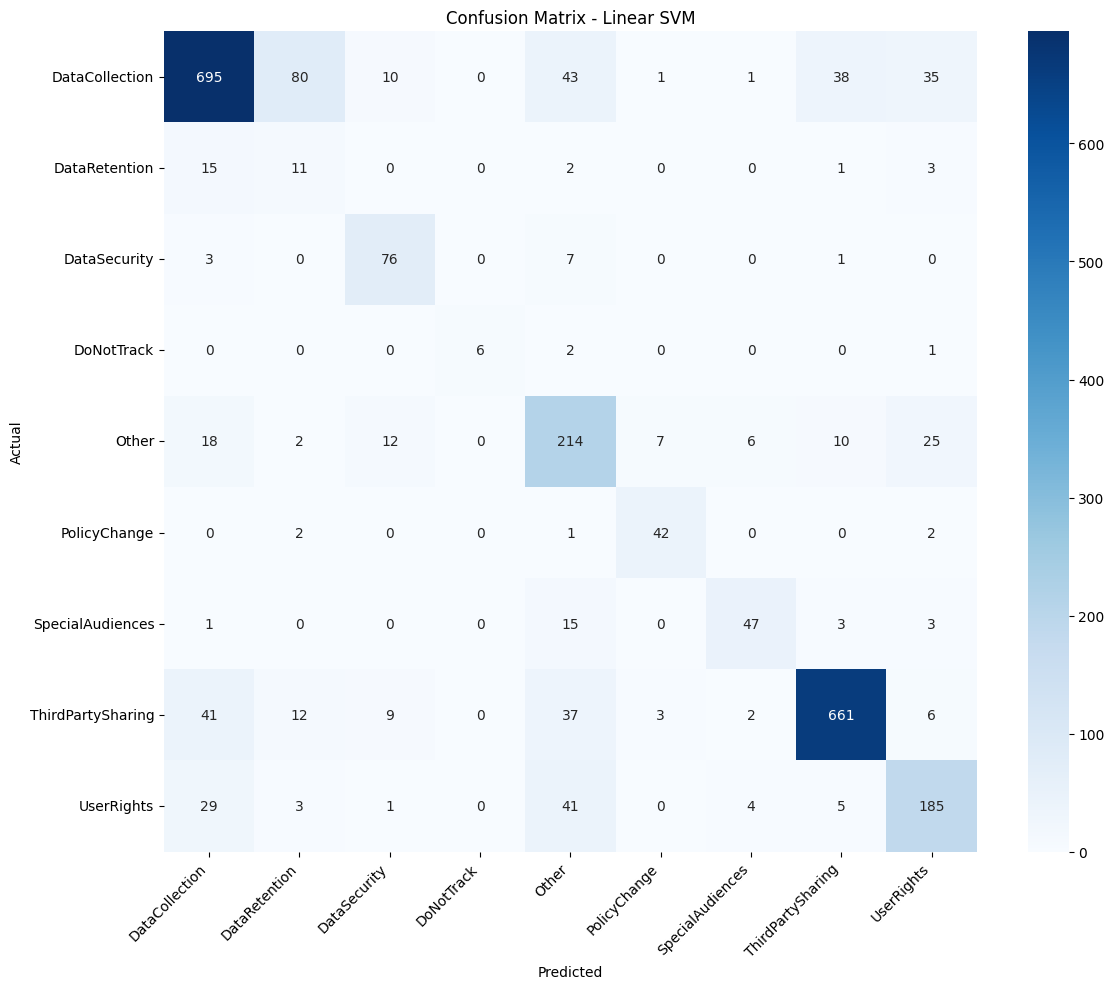

In [11]:
# Confusion Matrix
classes = sorted(y_test.unique())
cm = confusion_matrix(y_test, best_pred, labels=classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Model Comparison Summary

In [12]:
# Results comparison table
results_df = pd.DataFrame(all_results)
results_df = results_df.round(4)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
              model  precision  recall  f1_score  f2_score  train_time_sec  inference_time_sec  inference_per_sample_ms
Logistic Regression     0.8139  0.7609    0.7801    0.7661         31.8971              0.0017                   0.0007
         Linear SVM     0.8147  0.7810    0.7942    0.7851         11.1802              0.0014                   0.0006


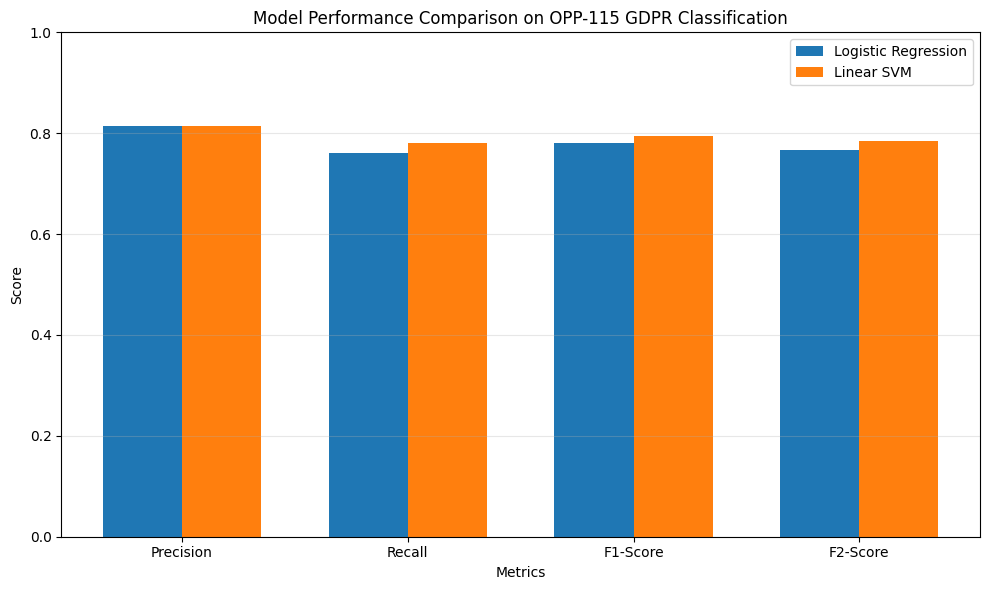

In [13]:
# Visual comparison
metrics = ['precision', 'recall', 'f1_score', 'f2_score']

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

for i, model in enumerate(results_df['model']):
    values = results_df[results_df['model'] == model][metrics].values[0]
    ax.bar(x + i*width, values, width, label=model)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison on OPP-115 GDPR Classification')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(['Precision', 'Recall', 'F1-Score', 'F2-Score'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Next Steps

Now that we have baseline results with lightweight models, the next steps are:

1. **Transformer Models**: Test BERT, RoBERTa with the existing pipeline in `utils.py`
2. **BiLSTM**: Test the BiLSTM model with word embeddings
3. **Gemma-3 LLM**: Add and test the Gemma-3 model for comparison
4. **Computational Metrics**: Track GPU/CPU usage and memory consumption

The current baseline establishes that:
- The OPP-115 dataset is successfully preprocessed and mapped to GDPR categories
- Traditional ML models can achieve reasonable classification performance
- Class imbalance exists and should be addressed (especially for DoNotTrack, DataRetention)

In [14]:
# Save results for later comparison
results_df.to_csv('Input/baseline_model_results.csv', index=False)
print("Baseline results saved to 'Input/baseline_model_results.csv'")

Baseline results saved to 'Input/baseline_model_results.csv'
